[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-3/edit-state-human-feedback.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239520-lesson-3-editing-state-and-human-feedback)

# Editing graph state

## Review

We discussed motivations for human-in-the-loop:

(1) `Approval` - We can interrupt our agent, surface state to a user, and allow the user to accept an action

(2) `Debugging` - We can rewind the graph to reproduce or avoid issues

(3) `Editing` - You can modify the state 

We showed how breakpoints support user approval, but don't yet know how to modify our graph state once our graph is interrupted!

## Goals

Now, let's show how to directly edit the graph state and insert human feedback.

In [ ]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai langgraph_sdk langgraph-prebuilt

In [ ]:
import os, getpass, sys
from langchain_anthropic import ChatAnthropic
from IPython.display import Image, display
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage
from langchain_core.runnables import RunnableConfig
import langchain_core
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState
from typing import Dict, List, Union, Literal
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode

from langchain_core.messages import HumanMessage, SystemMessage

#Import API Keys(storing them all in a seperate file so i run into less issues with git)
_root = "/home/zjc1002/Mounts/code/"
_langsmith_trace = 'true'
_langsmith_project = 'zjc_custom_v1'
_anthropic_model = 'claude-3-haiku-20240307'
_temparate = 0
_max_tokens = 4000
_streaming = True
_system_message = None
_db_path = "/home/zjc1002/Mounts/data/langgraph_memory/state_db/example1.db"
# This is a basic config to enable tracing of conversations and  utilization of memory
_config = {'configurable': {'thread_id':"1"}}

# Custom functions
sys.path.append(_root)
from  admin.api_keys import _api_keys
from admin.sys_ops import _set_env
from langgraph_projects.tools import get_weather, get_date, multiply, add, divide , internet_search

# This anthropic and internet tool requires  API key to be set as a environment variable(s)
for api_key in ["TAVILY_API_KEY","ANTHROPIC_API_KEY",'OPENAI_API_KEY','LANGSMITH_API_KEY']:
    _set_env(api_key
            ,value =  _api_keys[api_key])

## Editing state 

Previously, we introduced breakpoints.

We used them to interrupt the graph and await user approval before executing the next node.

But breakpoints are also [opportunities to modify the graph state](https://langchain-ai.github.io/langgraph/how-tos/human_in_the_loop/edit-graph-state/).

Let's set up our agent with a breakpoint before the `assistant` node.

In [2]:
# LLM
llm =  ChatAnthropic(
    model=_anthropic_model,
    temperature=_temparate,
    max_tokens=_max_tokens,
    streaming=_streaming,
    verbose=True,
)

#bind tools 
tools = [add, multiply, divide, internet_search, get_weather, get_date]
llm_with_tools = llm.bind_tools(tools)

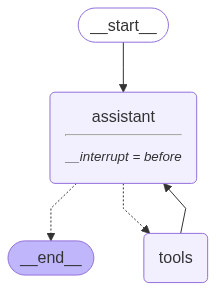

In [ ]:

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine the control flow
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")

memory = MemorySaver()
graph = builder.compile(interrupt_before=["assistant"], checkpointer=memory)

# Show
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

Let's run!

We can see the graph is interrupted before the chat model responds. 

In [4]:
# Input
initial_input = {"messages": "Multiply 2 and 3"}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3


In [5]:
state = graph.get_state(thread)
state

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='7ae93795-1a31-4238-a4e4-f6f2cd3f5981')]}, next=('assistant',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f03b434-0473-6224-8000-64aea6a676b0'}}, metadata={'source': 'loop', 'writes': None, 'step': 0, 'parents': {}, 'thread_id': '1'}, created_at='2025-05-27T21:40:47.574054+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f03b434-0470-6480-bfff-8c1e40f2894c'}}, tasks=(PregelTask(id='a4cd3b3b-59df-e3e2-b6ba-f6eb321ac107', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result=None),), interrupts=())

Now, we can directly apply a state update.

Remember, updates to the `messages` key will use the `add_messages` reducer:
 
* If we want to over-write the existing message, we can supply the message `id`.
* If we simply want to append to our list of messages, then we can pass a message without an `id` specified, as shown below.

In [6]:
graph.update_state(
    thread,
    {"messages": [HumanMessage(content="No, actually multiply 3 and 3!")]},
)

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f03b48e-11f2-6cfc-8001-6d00e4aa2816'}}

Let's have a look.

We called `update_state` with a new message. 

The `add_messages` reducer appends it to our state key, `messages`.

In [7]:
new_state = graph.get_state(thread).values
for m in new_state['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================ Human Message =================================

No, actually multiply 3 and 3!


Now, let's proceed with our agent, simply by passing `None` and allowing it proceed from the current state.

We emit the current and then proceed to execute the remaining nodes.

In [8]:
for event in graph.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

No, actually multiply 3 and 3!
================================== Ai Message ==================================

[{'text': "Okay, let's multiply 3 and 3:", 'type': 'text', 'index': 0}, {'id': 'toolu_012CrKXpVMFLnbhX3zQ4rpu4', 'input': {}, 'name': 'multiply', 'type': 'tool_use', 'index': 1, 'partial_json': '{"a": 3, "b": 3}'}]
Tool Calls:
  multiply (toolu_012CrKXpVMFLnbhX3zQ4rpu4)
 Call ID: toolu_012CrKXpVMFLnbhX3zQ4rpu4
  Args:
    a: 3
    b: 3
================================= Tool Message =================================
Name: multiply

9


Now, we're back at the `assistant`, which has our `breakpoint`.

We can again pass `None` to proceed.

In [9]:
for event in graph.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================= Tool Message =================================
Name: multiply

9
================================== Ai Message ==================================

[{'text': 'The result of multiplying 3 and 3 is 9.', 'type': 'text', 'index': 0}]


### Editing graph state in Studio

**⚠️ DISCLAIMER**

Since the filming of these videos, we've updated Studio so that it can be run locally and opened in your browser. This is now the preferred way to run Studio (rather than using the Desktop App as shown in the video). See documentation [here](https://langchain-ai.github.io/langgraph/concepts/langgraph_studio/#local-development-server) on the local development server and [here](https://langchain-ai.github.io/langgraph/how-tos/local-studio/#run-the-development-server). To start the local development server, run the following command in your terminal in the `/studio` directory in this module:

```
langgraph dev
```

You should see the following output:
```
- 🚀 API: http://127.0.0.1:2024
- 🎨 Studio UI: https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024
- 📚 API Docs: http://127.0.0.1:2024/docs
```

Open your browser and navigate to the Studio UI: `https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024`.

The LangGraph API [supports editing graph state](https://langchain-ai.github.io/langgraph/cloud/how-tos/human_in_the_loop_edit_state/#initial-invocation). 

In [ ]:
if 'google.colab' in str(get_ipython()):
    raise Exception("Unfortunately LangGraph Studio is currently not supported on Google Colab")

In [5]:
# This is the URL of the local development server
from langgraph_sdk import get_client
client = get_client(url="http://127.0.0.1:2024")

Our agent is defined in `studio/agent.py`. 

If you look at the code, you'll see that it *does not* have a breakpoint! 
 
Of course, we can add it to `agent.py`, but one very nice feature of the API is that we can pass in a breakpoint!

Here, we pass a `interrupt_before=["assistant"]`.

In [ ]:
initial_input = {"messages": "Multiply 2 and 3"}

# Create a new thread
thread = await client.threads.create()

# stream all events from the run
async for chunk in client.runs.stream(
    thread["thread_id"],
    "agent",
    input=initial_input,
    stream_mode="values",
    interrupt_before=["assistant"],
):
    print(f"Receiving new event of type: {chunk.event}...")
    messages = chunk.data.get('messages', [])
    if messages:
        print(messages[-1])
    print("-" * 50)

Receiving new event of type: metadata...
--------------------------------------------------
Receiving new event of type: values...
{'content': 'Multiply 2 and 3', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': '58046cac-c145-4aa8-84ce-2372b576d41c', 'example': False}
--------------------------------------------------


We can get the current state

In [7]:
current_state = await client.threads.get_state(thread['thread_id'])
current_state

{'values': {'messages': [{'content': 'Multiply 2 and 3',
    'additional_kwargs': {},
    'response_metadata': {},
    'type': 'human',
    'name': None,
    'id': '58046cac-c145-4aa8-84ce-2372b576d41c',
    'example': False}]},
 'next': ['assistant'],
 'tasks': [{'id': 'dc0b7d20-3a46-f794-a993-cc880758a7fa',
   'name': 'assistant',
   'path': ['__pregel_pull', 'assistant'],
   'error': None,
   'interrupts': [],
   'checkpoint': None,
   'state': None,
   'result': None}],
 'metadata': {'user-agent': 'langgraph-sdk-py/0.1.69',
  'x-request-id': 'd9ce6d4e-822d-4b50-a6ed-acdaceaad763',
  'langgraph_auth_user': None,
  'langgraph_auth_user_id': '',
  'langgraph_auth_permissions': [],
  'langgraph_request_id': 'd9ce6d4e-822d-4b50-a6ed-acdaceaad763',
  'graph_id': 'agent',
  'assistant_id': 'fe096781-5601-53d2-b2f6-0d3403f7e9ca',
  'user_id': '',
  'created_by': 'system',
  'run_attempt': 1,
  'langgraph_version': '0.4.5',
  'langgraph_plan': 'developer',
  'langgraph_host': 'self-hosted',

We can look at the last message in state.

In [8]:
last_message = current_state['values']['messages'][-1]
last_message

{'content': 'Multiply 2 and 3',
 'additional_kwargs': {},
 'response_metadata': {},
 'type': 'human',
 'name': None,
 'id': '58046cac-c145-4aa8-84ce-2372b576d41c',
 'example': False}

We can edit it!

In [9]:
last_message['content'] = "No, actually multiply 3 and 3!"
last_message

{'content': 'No, actually multiply 3 and 3!',
 'additional_kwargs': {},
 'response_metadata': {},
 'type': 'human',
 'name': None,
 'id': '58046cac-c145-4aa8-84ce-2372b576d41c',
 'example': False}

In [10]:
last_message

{'content': 'No, actually multiply 3 and 3!',
 'additional_kwargs': {},
 'response_metadata': {},
 'type': 'human',
 'name': None,
 'id': '58046cac-c145-4aa8-84ce-2372b576d41c',
 'example': False}

Remember, as we said before, updates to the `messages` key will use the same `add_messages` reducer. 

If we want to over-write the existing message, then we can supply the message `id`.

Here, we did that. We only modified the message `content`, as shown above.

In [15]:
await client.threads.update_state(thread['thread_id'], {"messages": last_message})

{'configurable': {'thread_id': 'a95ffa54-2435-4a47-a9da-e886369ca8ee',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef6a41d-cc8e-6979-8001-8c7c283b636c'},
 'checkpoint_id': '1ef6a41d-cc8e-6979-8001-8c7c283b636c'}

Now, we resume by passing `None`. 

In [16]:
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input=None,
    stream_mode="values",
    interrupt_before=["assistant"],
):
    print(f"Receiving new event of type: {chunk.event}...")
    messages = chunk.data.get('messages', [])
    if messages:
        print(messages[-1])
    print("-" * 50)

Receiving new event of type: metadata...
--------------------------------------------------
Receiving new event of type: values...
{'content': 'No, actually multiply 3 and 3!', 'additional_kwargs': {'additional_kwargs': {}, 'response_metadata': {}, 'example': False}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': '882dabe4-b877-4d71-bd09-c34cb97c4f46', 'example': False}
--------------------------------------------------
Receiving new event of type: values...
{'content': '', 'additional_kwargs': {'tool_calls': [{'index': 0, 'id': 'call_vi16je2EIikHuT7Aue2sd1qd', 'function': {'arguments': '{"a":3,"b":3}', 'name': 'multiply'}, 'type': 'function'}]}, 'response_metadata': {'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_157b3831f5'}, 'type': 'ai', 'name': None, 'id': 'run-775b42f7-0590-4c54-aaeb-78599b1f12d2', 'example': False, 'tool_calls': [{'name': 'multiply', 'args': {'a': 3, 'b': 3}, 'id': 'call_vi16je2EIikHuT7Aue2sd1qd', 'type

We get the result of the tool call as `9`, as expected.

In [17]:
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input=None,
    stream_mode="values",
    interrupt_before=["assistant"],
):
    print(f"Receiving new event of type: {chunk.event}...")
    messages = chunk.data.get('messages', [])
    if messages:
        print(messages[-1])
    print("-" * 50)

Receiving new event of type: metadata...
--------------------------------------------------
Receiving new event of type: values...
{'content': '9', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'tool', 'name': 'multiply', 'id': '226bfbad-0cea-4900-80c5-761a62bd4bc1', 'tool_call_id': 'call_vi16je2EIikHuT7Aue2sd1qd', 'artifact': None, 'status': 'success'}
--------------------------------------------------
Receiving new event of type: values...
{'content': 'The result of multiplying 3 by 3 is 9.', 'additional_kwargs': {}, 'response_metadata': {'finish_reason': 'stop', 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_157b3831f5'}, 'type': 'ai', 'name': None, 'id': 'run-859bbf47-9f35-4e71-ae98-9d93ee49d16c', 'example': False, 'tool_calls': [], 'invalid_tool_calls': [], 'usage_metadata': None}
--------------------------------------------------


## Awaiting user input

So, it's clear that we can edit our agent state after a breakpoint.

Now, what if we want to allow for human feedback to perform this state update?

We'll add a node that [serves as a placeholder for human feedback](https://langchain-ai.github.io/langgraph/how-tos/human_in_the_loop/wait-user-input/#setup) within our agent.

This `human_feedback` node allow the user to add feedback directly to state.
 
We specify the breakpoint using `interrupt_before` our `human_feedback` node.

We set up a checkpointer to save the state of the graph up until this node.

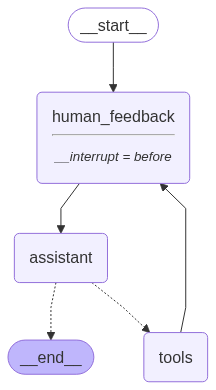

In [12]:
# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# no-op node that should be interrupted on
def human_feedback(state: MessagesState):
    pass

# Assistant node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))
builder.add_node("human_feedback", human_feedback)

# Define edges: these determine the control flow
builder.add_edge(START, "human_feedback")
builder.add_edge("human_feedback", "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "human_feedback")

memory = MemorySaver()
graph = builder.compile(interrupt_before=["human_feedback"], checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

We will get feedback from the user.

We use `.update_state` to update the state of the graph with the human response we get, as before.

We use the `as_node="human_feedback"` parameter to apply this state update as the specified node, `human_feedback`.

In [15]:
# Input
initial_input = {"messages": "Multiply 2 and 3"}

# Thread
thread = {"configurable": {"thread_id": "5"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()
    
# Get user input
user_input = input("Tell me how you want to update the state: ")

# We now update the state as if we are the human_feedback node
# APPLYS THE UPDATE TO STATE AS IF THE HUMAN FEEDBACK NODE RAN IT 
graph.update_state(thread, {"messages": user_input}, as_node="human_feedback")

# Continue the graph execution
for event in graph.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================ Human Message =================================

no multiply 3 & 3
================================== Ai Message ==================================

[{'text': "Okay, let's do the multiplications step-by-step:", 'type': 'text', 'index': 0}, {'id': 'toolu_01Mk222VYEDZ1WayvMyAdTKk', 'input': {}, 'name': 'multiply', 'type': 'tool_use', 'index': 1, 'partial_json': '{"a": 2, "b": 3}'}]
Tool Calls:
  multiply (toolu_01Mk222VYEDZ1WayvMyAdTKk)
 Call ID: toolu_01Mk222VYEDZ1WayvMyAdTKk
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6


In [16]:
# Continue the graph execution
for event in graph.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

[{'text': "Now let's multiply 3 and 3:", 'type': 'text', 'index': 0}, {'id': 'toolu_012DWVPNbV59hhqmHRt7ttqr', 'input': {}, 'name': 'multiply', 'type': 'tool_use', 'index': 1, 'partial_json': '{"a": 3, "b": 3}'}]
Tool Calls:
  multiply (toolu_012DWVPNbV59hhqmHRt7ttqr)
 Call ID: toolu_012DWVPNbV59hhqmHRt7ttqr
  Args:
    a: 3
    b: 3
================================= Tool Message =================================
Name: multiply

9
